# Image Classification using AWS Sagemaker

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.
This notebook explains the necesary steps to train a torchvision model, including the hyperparameter tunning phase managed with on-demand hardware infrastructure within AWS Sagemaker. It also exposes tools for debugging and profiling the training phase using Sagemaker. Lastly, it shows how to deploy the trained pytorch model to an endpoint, in order to serve the model for inference.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [ ]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug
!pip install torchvision
!pip install torch

In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.pytorch import PyTorch

from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    rule_configs,
)

from sagemaker.debugger import Rule, ProfilerRule

## Dataset
I choose the dog breeds dataset. It is dividen into three folders (train, test, valid), Each one of them has 133 subfolder for each breed, and inside those subfolder reside the dogs' images, we need to highlight that images size are different between each other. We have 6680 training images, 636 test images, and 835 validation images.

In [ ]:
!ls dogImages/valid/*/* | wc -l

In [ ]:
# TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
# !wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImagesSubset.zip

In [4]:
sess = sagemaker.Session()
bucket = sess.default_bucket()                    # Set a default S3 bucket
prefix = 'deep-learning-models-on-sagemaker-project'
role = sagemaker.get_execution_role()
sess, bucket, role

(<sagemaker.session.Session at 0x7fe6b2f5cfd0>,
 'sagemaker-us-east-1-155431344840',
 'arn:aws:iam::155431344840:role/service-role/AmazonSageMaker-ExecutionRole-20221019T135057')

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

Answer: Learning rate, momentum and batch-size are important parameters whose have a direct impact in the performance of the model, they can avoid both, overfitting and underfitting. They can also accelerate the gradient for reducing the loss.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [4]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "momentum": ContinuousParameter(0.1, 0.9),
    "batch-size": CategoricalParameter([8, 16, 32, 64]),
}

In [7]:
#TODO: Create estimators for your HPs

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large"
)# TODO: Your estimator here

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: (\-?[0-9\\.]+)"}]

tuner = tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=9,
    max_parallel_jobs=3,
    objective_type=objective_type,
)# TODO: Your HP tuner here

In [12]:
s3_data = "s3://sagemaker-us-east-1-155431344840/deep-learning-models-on-sagemaker-project/dogImagesSubset"
# s3_data = "s3://sagemaker-us-east-1-155431344840/deep-learning-models-on-sagemaker-project/dogImages"

In [10]:
# TODO: Fit your HP Tuner
tuner.fit({"training":s3_data}) # TODO: Remember to include your data channels

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [12]:
# TODO: Get the best estimators and the best HPs
best_estimator = tuner.best_estimator()#TODO

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-11-18 02:45:33 Starting - Found matching resource for reuse
2022-11-18 02:45:33 Downloading - Downloading input data
2022-11-18 02:45:33 Training - Training image download completed. Training in progress.
2022-11-18 02:45:33 Uploading - Uploading generated training model
2022-11-18 02:45:33 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"8"',
 'lr': '0.01364056232805739',
 'momentum': '0.5155036728264019',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-11-18-00-30-23-285"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-155431344840/pytorch-training-2022-11-18-00-30-23-285/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [10]:
# TODO: Set up debugging and profiling rules and hooks
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    # ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    # ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

# hook_config = DebuggerHookConfig(
#     hook_parameters={"train.save_interval": "10", "eval.save_interval": "1"}
# )

hook_config = DebuggerHookConfig(
    hook_parameters={"save_interval": "10"}
)

from sagemaker.debugger import ProfilerConfig, FrameworkProfile
profiler_config=ProfilerConfig(
    system_monitor_interval_millis=1000,
    framework_profile_params=FrameworkProfile()
)


hyperparameters = {"epochs": "5", "batch-size": "8", "test-batch-size": "8", "lr": "0.01364056232805739", "momentum": "0.5155036728264019"}

In [11]:
# TODO: Create and fit an estimator

estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="image-classification-course-project-pytorch",
    role=role,
    instance_count=1,
    instance_type="ml.m5.large",
    hyperparameters=hyperparameters,
    framework_version="1.8",
    py_version="py36",
    ## Debugger parameters
    rules=rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)# TODO: Your estimator here

In [16]:
estimator.fit({"training":s3_data}, wait=True)

2022-11-18 16:58:42 Starting - Starting the training job...
2022-11-18 16:58:59 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LossNotDecreasing: InProgress
ProfilerReport-1668790722: InProgress
......
2022-11-18 17:00:04 Downloading - Downloading input data......
2022-11-18 17:01:05 Training - Downloading the training image...
2022-11-18 17:01:36 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-11-18 17:01:38,604 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-11-18 17:01:38,607 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-11-18 17:01:38,615 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-11-18 17:01:38,622

In [17]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)
job_name, client, description

('image-classification-course-project-pyt-2022-11-18-16-58-42-607',
 {'TrainingJobName': 'image-classification-course-project-pyt-2022-11-18-16-58-42-607',
  'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:155431344840:training-job/image-classification-course-project-pyt-2022-11-18-16-58-42-607',
  'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-155431344840/image-classification-course-project-pyt-2022-11-18-16-58-42-607/output/model.tar.gz'},
  'TrainingJobStatus': 'Completed',
  'SecondaryStatus': 'Completed',
  'HyperParameters': {'batch-size': '"8"',
   'epochs': '"5"',
   'lr': '"0.01364056232805739"',
   'momentum': '"0.5155036728264019"',
   'sagemaker_container_log_level': '20',
   'sagemaker_job_name': '"image-classification-course-project-pyt-2022-11-18-16-58-42-607"',
   'sagemaker_program': '"train_model.py"',
   'sagemaker_region': '"us-east-1"',
   'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-155431344840/image-classification-course-project-pyt

In [44]:
!pip install smdebug

In [22]:
debugger_artifacts_s3_path = estimator.latest_job_debugger_artifacts_path()
debugger_artifacts_s3_path

's3://sagemaker-us-east-1-155431344840/image-classification-course-project-pyt-2022-11-18-16-58-42-607/debug-output'

In [23]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
# 's3://sagemaker-us-east-1-155431344840/image-classification-course-project-pyt-2022-11-18-03-01-03-952/debug-output'

trial = create_trial(debugger_artifacts_s3_path)
trial.tensor_names()

[2022-11-18 17:07:06.321 pytorch-1-10-cpu-py38-ml-t3-medium-9c8fa3a7688fa232cbbe37185a11:29 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-11-18 17:07:06.425 pytorch-1-10-cpu-py38-ml-t3-medium-9c8fa3a7688fa232cbbe37185a11:29 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-155431344840/image-classification-course-project-pyt-2022-11-18-16-58-42-607/debug-output


/opt/conda/lib/python3.8/site-packages/smdebug-1.0.13b20220304-py3.8.egg/smdebug/profiler/system_metrics_reader.py:63: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/opt/conda/lib/python3.8/site-packages/smdebug-1.0.13b20220304-py3.8.egg/smdebug/profiler/system_metrics_reader.py:63: SyntaxWarning: "is not" with a literal. Did you mean "!="?


[2022-11-18 17:07:06.759 pytorch-1-10-cpu-py38-ml-t3-medium-9c8fa3a7688fa232cbbe37185a11:29 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2022-11-18 17:07:07.776 pytorch-1-10-cpu-py38-ml-t3-medium-9c8fa3a7688fa232cbbe37185a11:29 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.bias',
 'gradient/ResNet_fc.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer4.0.relu_input_0',
 'layer4.0.relu_input_1',
 'layer4.1.relu_input_0',
 'layer4.1.relu_input_1',
 'relu_input_0',
 'scalar/accuracy']

In [28]:
# len(trial.tensor("nll_loss_output_0").steps(mode=ModeKeys.TRAIN))
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))

1

In [25]:
# len(trial.tensor("nll_loss_output_0").steps(mode=ModeKeys.EVAL))
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))

1

In [64]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


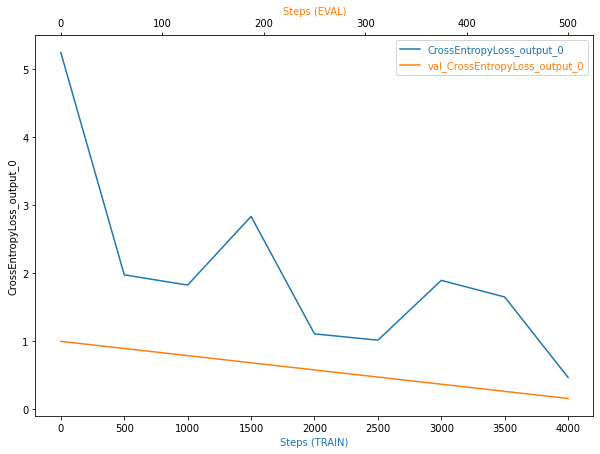

In [65]:
# TODO: Plot a debugging output.
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it? 
Answer: I think the model didn't reduce a lot of its loss in the last steps, maybe it is not necessary to train the whole 5 epochs.
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [29]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-155431344840/image-classification-course-project-pyt-2022-11-18-16-58-42-607/rule-output


In [30]:
! aws s3 ls {rule_output_path} --recursive

2022-11-18 17:05:32     375832 image-classification-course-project-pyt-2022-11-18-16-58-42-607/rule-output/ProfilerReport-1668790722/profiler-output/profiler-report.html
2022-11-18 17:05:32     223775 image-classification-course-project-pyt-2022-11-18-16-58-42-607/rule-output/ProfilerReport-1668790722/profiler-output/profiler-report.ipynb
2022-11-18 17:05:27        191 image-classification-course-project-pyt-2022-11-18-16-58-42-607/rule-output/ProfilerReport-1668790722/profiler-output/profiler-reports/BatchSize.json
2022-11-18 17:05:27        199 image-classification-course-project-pyt-2022-11-18-16-58-42-607/rule-output/ProfilerReport-1668790722/profiler-output/profiler-reports/CPUBottleneck.json
2022-11-18 17:05:27       2224 image-classification-course-project-pyt-2022-11-18-16-58-42-607/rule-output/ProfilerReport-1668790722/profiler-output/profiler-reports/Dataloader.json
2022-11-18 17:05:27        127 image-classification-course-project-pyt-2022-11-18-16-58-42-607/rule-output/Prof

In [31]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-155431344840/image-classification-course-project-pyt-2022-11-18-16-58-42-607/rule-output/ProfilerReport-1668790722/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport-1668790722/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-155431344840/image-classification-course-project-pyt-2022-11-18-16-58-42-607/rule-output/ProfilerReport-1668790722/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport-1668790722/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-155431344840/image-classification-course-project-pyt-2022-11-18-16-58-42-607/rule-output/ProfilerReport-1668790722/profiler-output/profiler-reports/BatchSize.json to ProfilerReport-1668790722/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-155431344840/image-classification-course-project-pyt-2022-11-18-16-58-42-607/rule-output/ProfilerReport-1668790722/p

In [69]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]
profiler_report_name

'ProfilerReport'

In [ ]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [72]:
# TODO: Deploy your model to an endpoint
from sagemaker.pytorch import PyTorchModel
# predictor=estimator.deploy(initial_instance_count=1, instance_type="ml.m5.large") # TODO: Add your deployment configuration like instance type and number of instances
pytorch_model = PyTorchModel(model_data='s3://sagemaker-us-east-1-155431344840/image-classification-course-project-pyt-2022-11-18-04-43-23-799/output/model.tar.gz', role=role, entry_point='inference.py', framework_version="1.8",
    py_version="py36",)
predictor = pytorch_model.deploy(instance_type='ml.m5.large', initial_instance_count=1)

------!

In [73]:
from sagemaker.serializers import IdentitySerializer
predictor.serializer = IdentitySerializer("image/jpeg")
from PIL import Image
from IPython.display import Image as ImageDisplay
import io
import numpy as np

def identify_dog(image_path):    
    buf = io.BytesIO()
    Image.open(image_path).save(buf, format="JPEG")
    response = predictor.predict(buf.getvalue())
    
    return response


In [74]:
# TODO: Run an prediction on the endpoint
image = 'dogImages/valid/027.Bloodhound/Bloodhound_01931.jpg' # bloodhound has the 26 label
response = identify_dog(image)
np.argmax(response, 1)

array([26])

In [71]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

ClientError: An error occurred (ValidationException) when calling the DeleteEndpointConfig operation: Could not find endpoint configuration "arn:aws:sagemaker:us-east-1:155431344840:endpoint-config/pytorch-inference-2022-11-18-04-07-24-295".

In [ ]:
import torch
from torchvision import datasets, models, transforms
import torchvision
def get_valid_data_loader():
    transform = transforms.Compose([transforms.RandomResizedCrop(224), transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    testset = datasets.ImageFolder("dogImagesSubset/valid", transform = transform)
    return torch.utils.data.DataLoader(testset, batch_size=2, shuffle=False, num_workers=2)
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
validLoader = get_valid_data_loader()
dataiter = iter(validLoader)

images, labels = dataiter.next()

# print images

imshow(torchvision.utils.make_grid(images))

outputs = predictor.predict(images.numpy())

_, predicted = torch.max(torch.from_numpy(np.array(outputs)), 1)
